# Model SVM

In [1]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import GridSearchCV,RepeatedKFold, RepeatedStratifiedKFold, KFold, cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, accuracy_score, f1_score
import os
import pickle
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_data(raw_clinical_note):
    data = pd.read_csv(raw_clinical_note, header=0,na_filter=True)
    return data

def delete_columns(data,columns): 
    df = data.drop(columns,axis=1)
    return df

def generating_metrics_svm(model,x, y):
    y_pred = model.predict(x)
    acc = accuracy_score(y,y_pred)
    tn, fp, fn, tp = confusion_matrix(y,y_pred).ravel()
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y, y_pred)
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    auc_score = auc(false_positive_rate, true_positive_rate)
    f1 = f1_score(y, y_pred)
    print("auc_test: {}, sens_test {}, spec_test: {}, f1_test {}, acc_test {}".format(auc_score, sensitivity, specificity, f1, acc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(false_positive_rate, true_positive_rate, label='Testing (AUC=%0.2f)' % auc_score, color='darkorange')
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.legend(loc='best')
    plt.title('ROC of the SVM model')
    plt.show()

def plot_roc(model,X_test, y_test,name,logs_file):
    print("mean_cross_val_score: ", model.best_score_)
    print("best_params:",model.best_params_)
    print("=============================================================================")
    auc_test, sens_test, spec_test, f1_test, acc_test,fpr_test, tpr_test = generating_metrics(model, X_test, y_test)
    print("auc_test: {}, sens_test {}, spec_test: {}, f1_test {}, acc_test {}".format(auc_test, sens_test, spec_test, f1_test, acc_test))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_test, tpr_test, label='Testing (AUC=%0.2f)' % auc_test, color='darkorange')
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.legend(loc='best')
    plt.title('ROC of the SVM model')
    fig_name = name + '.pdf'
    url_save = os.path.join(logs_file,str(fig_name))
    plt.savefig(url_save)
    plt.show()
            
def saving_model(model,model_name,logs_file):
    import joblib
    model_name = model_name + '.pkl'
    url_save = os.path.join(logs_file,str(model_name))
    print(url_save)
    joblib.dump(model, url_save)

def generating_metrics_svm(model,x, y, name, logs_file):
    print("mean_cross_val_score: ", model.best_score_)
    print("best_params:",model.best_params_)
    y_pred = model.predict(x)
    acc = accuracy_score(y,y_pred)
    tn, fp, fn, tp = confusion_matrix(y,y_pred).ravel()
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y, y_pred)
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    auc_score = auc(false_positive_rate, true_positive_rate)
    f1 = f1_score(y, y_pred)
    
    print("auc_test: {}, sens_test {}, spec_test: {}, f1_test {}, acc_test {}".format(auc_score, sensitivity, specificity, f1, acc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(false_positive_rate, true_positive_rate, label='Testing (AUC=%0.2f)' % auc_score, color='darkorange')
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.legend(loc='best')
    plt.title('ROC of the SVM model')
    fig_name = name + '.pdf'
    url_save = os.path.join(logs_file,str(fig_name))
    plt.savefig(url_save)
    plt.show()

In [3]:
raw_data = 'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/data_final_mor.csv'
data = pd.read_csv(raw_data)
print ("Total de registros", data.shape[0])

Total de registros 11564


In [4]:
data.columns

Index(['Unnamed: 0', 'Sex', 'Age', 'Pregnancy', 'Fever', 'Cough',
       'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea', 'Chest pain',
       'Chills', 'Headache', 'Myalgia', 'Arthralgia', 'General discomfort',
       'Rhinorrhea', 'Polypnea', 'Vomiting', 'Abdominal pain',
       'Conjunctivitis', 'Cyanosis', 'Sudden onset of symptoms', 'Anosmia',
       'Dysgeusia', 'Diabetes', 'COPD', 'Asthma', 'Immunosuppression',
       'Hypertension', 'HIV AIDS', 'Cardiovascular disease', 'Obesity', 'CKD',
       'Smoking', 'Puerperium', 'Use of antipyretics', 'Mortality',
       'Days elapsed'],
      dtype='object')

In [5]:
X = data.drop(['Unnamed: 0','Mortality'],axis=1).astype(int)
y = data['Mortality'].astype(int) 
y = y.values.reshape(y.shape[0],1) 
feature_list = X.columns
print("X::", X.shape)
print("Y::", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=242,stratify=y)


X:: (11564, 37)
Y:: (11564, 1)


In [6]:
from sklearn import svm
clf = svm.SVC()

In [7]:
X.columns

Index(['Sex', 'Age', 'Pregnancy', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'HIV AIDS',
       'Cardiovascular disease', 'Obesity', 'CKD', 'Smoking', 'Puerperium',
       'Use of antipyretics', 'Days elapsed'],
      dtype='object')

In [8]:
X.columns.shape[0]

37

In [9]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=442)
sample_weights = class_weight.compute_sample_weight('balanced', y_train) 
parameters={ 'C':np.logspace(-4, 4, 5),
            'class_weight': ['balanced'],
            'gamma':['scale','auto'],
            'random_state': [422]}
grid = GridSearchCV(estimator=clf, param_grid=parameters, cv=cv,scoring='roc_auc',refit = True)
model = grid.fit(X_train,y_train,sample_weight = sample_weights)

mean_cross_val_score:  0.8110732160312141
best_params: {'C': 1.0, 'class_weight': 'balanced', 'gamma': 'scale', 'random_state': 422}
auc_test: 0.6525543265739344, sens_test 0.9969135802469136, spec_test: 0.30819507290095527, f1_test 0.319327731092437, acc_test 0.4046692607003891


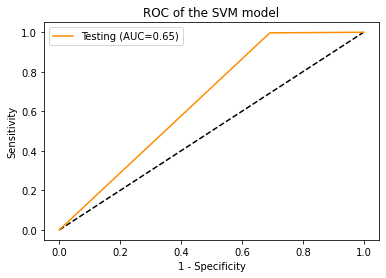

In [10]:
generating_metrics_svm(model,X_test, y_test,"auc_svm1","C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/AUC")

In [11]:
saving_model(model,"modelSVM1","C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/PKL")

C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/PKL\modelSVM1.pkl
